## Pipeline
## ----------
## Must be run before running any other piece of code in this notebook

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
import time
import numpy.ma as ma


def p_corr_fun(r, r0, delta):
    A = (1 - delta)/(pow(r0, delta) * (pow(10, 1 - delta) - pow(0.5, 1 - delta)))
    return A * pow(r/r0, -delta) 

xi_r = np.vectorize(p_corr_fun)

def get_r_from_prob(r0, delta):
    c = np.random.uniform(0, 1, 1)[0]
    A = (1 - delta)/(pow(r0, delta) * (pow(10, 1 - delta) - pow(0.5, 1 - delta)))
    temp1 = (1 - delta)/(A * pow(r0, delta)) * c + pow(0.5, 1 - delta)
    return pow(temp1, 1/(1 - delta))

get_r_from_prob_vec = np.vectorize(get_r_from_prob)

def make_clust_dist(num, r0, delta):
    dat_array = np.random.uniform(0, 10, (3, 1))
    i = 0

    while i < (num - 1):
        r = get_r_from_prob(r0, delta)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arccos(z/r)
        if np.isnan(theta):
            print(z/r)

        new_add = np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), z])
        new_pt = np.reshape(dat_array[:,-1] + new_add, (3,1))
        if np.any(((new_pt < [[0], [0], [0]]) | (new_pt > [[10], [10], [10]]))):
            continue
        
        dat_array = np.append(dat_array, new_pt, axis=1)
        i += 1

    return dat_array

def calc_corr_fun(x_dat, y_dat, z_dat, x_ran, y_ran, z_ran, bins, r0=None, delta=None):
    
    bin_avg = np.array((bins[:-1] + bins[1:])/2)

    results = DD(autocorr=1, nthreads=1, binfile=bins, X1=x_ran, Y1=y_ran, Z1=z_ran, periodic=False)
    results = np.array(list(map(list, results)))
    RR_count = results[:,3]/2
    #plt.stairs(RR_count, bins)

    results = DD(autocorr=1, nthreads=1, binfile=bins, X1=x_dat, Y1=y_dat, Z1=z_dat, periodic=False)
    results = np.array(list(map(list, results)))
    DD_count = results[:,3]/2
    #plt.stairs(DD_count, bins)

    results = DD(autocorr=0, nthreads=1, binfile=bins, X1=x_dat, Y1=y_dat, Z1=z_dat, X2=x_ran, Y2=y_ran, Z2=z_ran, periodic=False)
    results = np.array(list(map(list, results)))
    DR_count = results[:,3]
    #plt.stairs(DR_count, bins)

    DD_norm = (len(x_dat) * (len(x_dat) - 1))/2
    RR_norm = (len(x_ran) * (len(x_ran) - 1))/2
    DR_norm = len(x_dat) * len(x_ran)

    xi = ma.masked_values(DD_count * RR_count * DR_count, 0)
    xi[~xi.mask]= (DD_count[~xi.mask]/DD_norm - 2 * DR_count[~xi.mask]/DR_norm + RR_count[~xi.mask]/RR_norm)/ (RR_count[~xi.mask]/RR_norm)


    fig, ax = plt.subplots(figsize=(7,7))
    ax.plot(bin_avg, xi, '.', label=r"$\xi$ of the simulation")
    ax.plot(bin_avg[xi.mask], np.zeros_like(bin_avg[xi.mask]), 'r.', label="bins with any of the counts zero")
    ax.axhline(0)
    ax.set_xlabel('r')
    ax.set_ylabel(r'$\xi(r)$')
    if r0==None:
        ax.set_title("Correlation function")
    else:
        ax.set_title("data with pow law clustering with $r_0$ = {}, $\delta$ = {}, $n_d$ = {}, $n_r$ = {}".format(r0, delta, len(x_dat), len(x_ran)))

        r_vals = bins
        xi_vals = xi_r(r_vals, r0, delta)

        ax.plot(r_vals, xi_vals, label="pow law function")
    ax.legend()
    return ax

## Simulation of clustered data in 3d box

In [11]:
x_ran, y_ran, z_ran = np.random.uniform(0, 10, (3,1000))

Text(0.5, 0.92, 'Distribution of the unclustered points in a box')

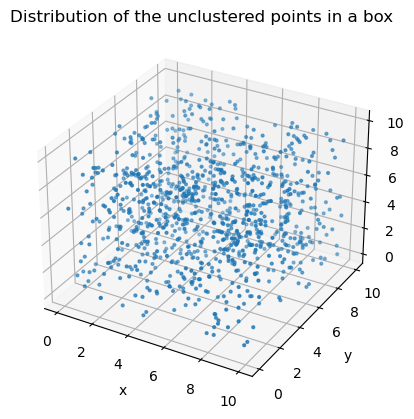

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_ran, y_ran, z_ran, s=4)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Distribution of the unclustered points in a box")

Text(0.5, 0, '$r$')

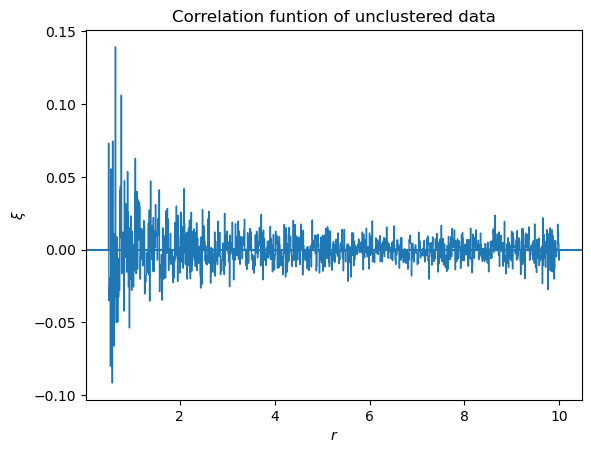

In [13]:
x_dat, y_dat, z_dat = np.random.uniform(0, 10, (3, 10000))
x_ran, y_ran, z_ran = np.random.uniform(0, 10, (3, 10000))

bins = np.linspace(0.5, 10, 1000)

results = DD(autocorr=1, nthreads=1, binfile=bins, X1=x_ran, Y1=y_ran, Z1=z_ran, periodic=False)
results = np.array(list(map(list, results)))
RR_count = results[:,3]/2
#plt.stairs(RR_count, bins)

results = DD(autocorr=1, nthreads=1, binfile=bins, X1=x_dat, Y1=y_dat, Z1=z_dat, periodic=False)
results = np.array(list(map(list, results)))
DD_count = results[:,3]/2
#plt.stairs(DD_count, bins)

results = DD(autocorr=0, nthreads=1, binfile=bins, X1=x_dat, Y1=y_dat, Z1=z_dat, X2=x_ran, Y2=y_ran, Z2=z_ran, periodic=False)
results = np.array(list(map(list, results)))
DR_count = results[:,3]
#plt.stairs(DR_count, bins)

DD_norm = (len(x_dat) * (len(x_dat) - 1))/2
RR_norm = (len(x_ran) * (len(x_ran) - 1))/2
DR_norm = len(x_dat) * len(x_ran)

xi = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/ (RR_count/RR_norm)

plt.stairs(xi, bins)
plt.axhline(0)
plt.title("Correlation funtion of unclustered data")
plt.ylabel(r"$\xi$")
plt.xlabel(r"$r$")

Text(0.5, 0, 'r')

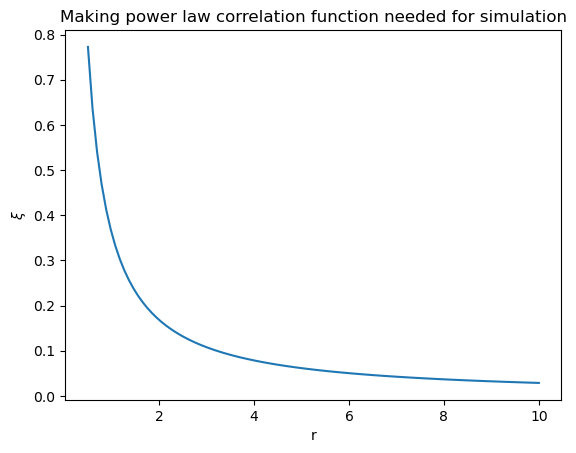

In [14]:
def p_corr_fun(r, r0, delta):
    A = (1 - delta)/(pow(r0, delta) * (pow(10, 1 - delta) - pow(0.5, 1 - delta)))
    return A * pow(r/r0, -delta) 

xi_r = np.vectorize(p_corr_fun)

r_vals = np.linspace(0.5, 10, 100)
xi_vals = xi_r(r_vals, 1.0, 1.1)

plt.plot(r_vals, xi_vals)
plt.title("Making power law correlation function needed for simulation")
plt.ylabel(r"$\xi$")
plt.xlabel("r")

Text(0, 0.5, 'Number count')

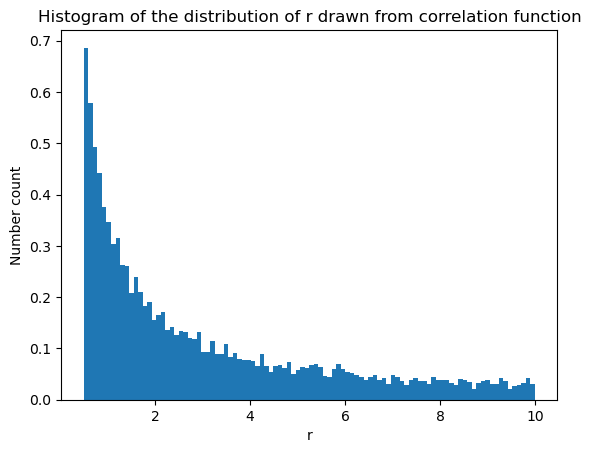

In [15]:
def get_r_from_prob(c, r0, delta):
    A = (1 - delta)/(pow(r0, delta) * (pow(10, 1 - delta) - pow(0.5, 1 - delta)))
    temp1 = (1 - delta)/(A * pow(r0, delta)) * c + pow(0.5, 1 - delta)
    return pow(temp1, 1/(1 - delta))

get_r_from_prob_vec = np.vectorize(get_r_from_prob)
ran_01 = np.random.uniform(0, 1, 10000)

r_rans = get_r_from_prob_vec(ran_01, 1.0, 1.1)
plt.hist(r_rans, 100, density=True);
plt.title("Histogram of the distribution of r drawn from correlation function")
plt.xlabel("r")
plt.ylabel("Number count")

In [4]:
def make_clust_dist(num, r0, delta):
    dat_array = np.random.uniform(0, 10, (3, 1))

    for i in range(num - 1):
        c = np.random.uniform(0, 1, 1)[0]
        r = get_r_from_prob(c, r0, delta)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arccos(z/r)
        if np.isnan(theta):
            print(z/r)

        new_add = np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), z])
        new_pt = np.reshape(dat_array[:,-1] + new_add, (3,1))
        if np.any(((new_pt < [[0], [0], [0]]) | (new_pt > [[10], [10], [10]]))):
            continue
        
        dat_array = np.append(dat_array, new_pt, axis=1)

    return dat_array

Text(0.5, 0.92, 'Distribution of clustered points following power law')

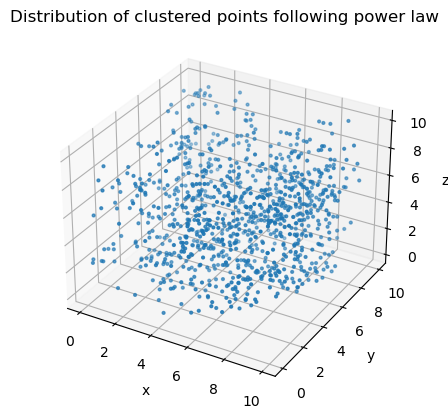

In [16]:
x, y, z = make_clust_dist(1000, 1.0, 1.1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, s=4)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Distribution of clustered points following power law")

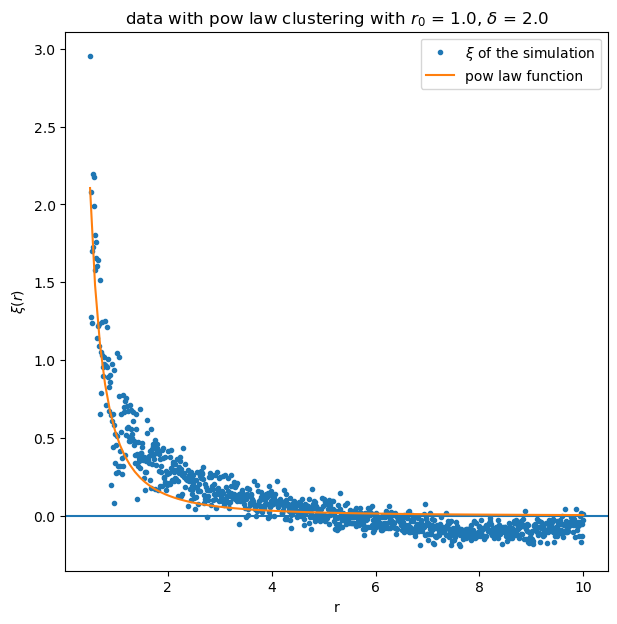

In [17]:
r0 = 1.0
delta = 2.0

x_dat, y_dat, z_dat = make_clust_dist(1000, r0, delta)
x_ran, y_ran, z_ran = np.random.uniform(0, 10, (3, 10000))

bins = np.linspace(0.5, 10, 1000)
bin_avg = (bins[:-1] + bins[1:])/2

results = DD(autocorr=1, nthreads=1, binfile=bins, X1=x_ran, Y1=y_ran, Z1=z_ran, periodic=False)
results = np.array(list(map(list, results)))
RR_count = results[:,3]/2
#plt.stairs(RR_count, bins)

results = DD(autocorr=1, nthreads=1, binfile=bins, X1=x_dat, Y1=y_dat, Z1=z_dat, periodic=False)
results = np.array(list(map(list, results)))
DD_count = results[:,3]/2
#plt.stairs(DD_count, bins)

results = DD(autocorr=0, nthreads=1, binfile=bins, X1=x_dat, Y1=y_dat, Z1=z_dat, X2=x_ran, Y2=y_ran, Z2=z_ran, periodic=False)
results = np.array(list(map(list, results)))
DR_count = results[:,3]
#plt.stairs(DR_count, bins)

DD_norm = (len(x_dat) * (len(x_dat) - 1))/2
RR_norm = (len(x_ran) * (len(x_ran) - 1))/2
DR_norm = len(x_dat) * len(x_ran)

xi = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/ (RR_count/RR_norm)

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(bin_avg, xi, '.', label=r"$\xi$ of the simulation")
ax.axhline(0)
ax.set_xlabel('r')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("data with pow law clustering with $r_0$ = {}, $\delta$ = {}".format(r0, delta))

r_vals = np.linspace(0.5, 10, 100)
xi_vals = xi_r(r_vals, r0, delta)

ax.plot(r_vals, xi_vals, label="pow law function")
ax.legend()

#### Note: A systematic error is observed in the measured correlation function of clustered data

## Analysis of simulation of clustered data in 3d box under various conditions

In [5]:
def Look_into(r0, delta, n_d, n_r, bins):
    start = time.time()

    x_dat, y_dat, z_dat = make_clust_dist(n_d, r0, delta)
    x_ran, y_ran, z_ran = np.random.uniform(0, 10, (3, n_r))

    ax = calc_corr_fun(x_dat, y_dat, z_dat, x_ran, y_ran, z_ran, bins, r0, delta)

    end = time.time()
    print("Total time take = {} s".format(round(end-start,2)))

    return ax

Total time take = 3.65 s


(-0.2, 3.0)

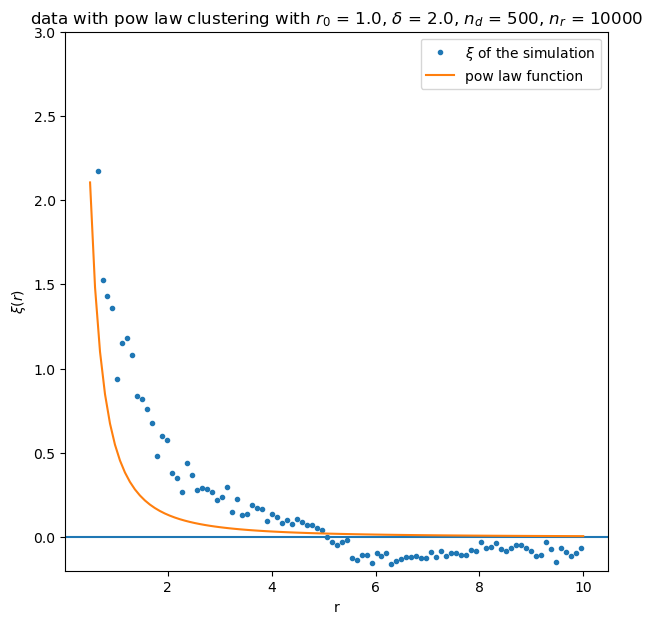

In [42]:
ax = Look_into(r0 = 1.0, delta = 2.0, n_d = 500, n_r = 10000, bins = np.linspace(0.5, 10, 100))
ax.set_ylim(-0.2, 3)

Total time take = 3.75 s


(-0.2, 2.0)

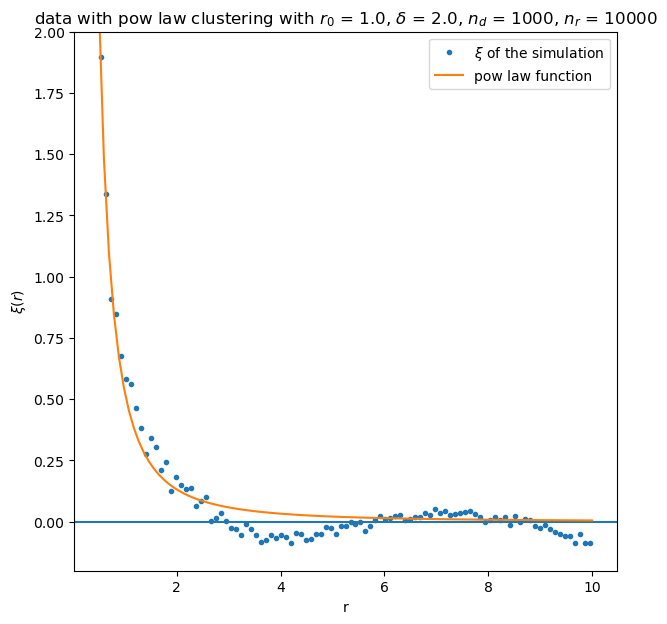

In [22]:
ax = Look_into(r0 = 1.0, delta = 2.0, n_d = 1000, n_r = 10000, bins = np.linspace(0.5, 10, 100))
ax.set_ylim(-0.2, 2)

Total time take = 4.72 s


(-0.2, 2.0)

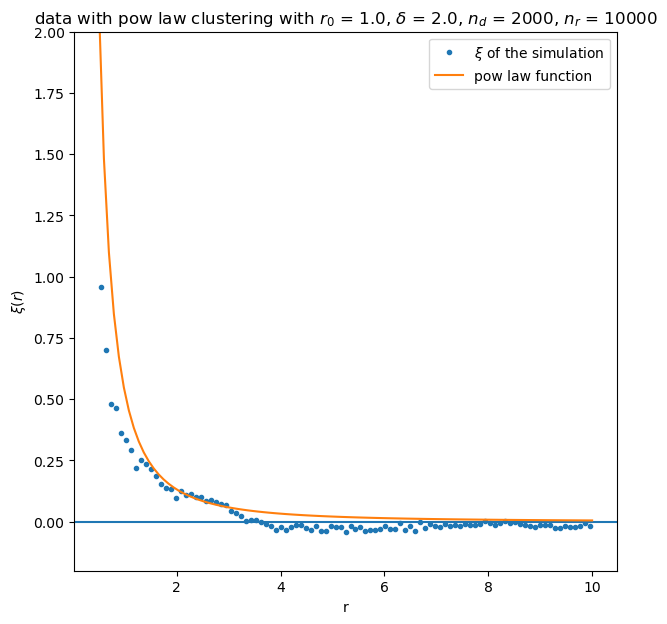

In [38]:
ax = Look_into(r0 = 1.0, delta = 2.0, n_d = 2000, n_r = 10000, bins = np.linspace(0.5, 10, 100))
ax.set_ylim(-0.2, 2)

Total time take = 4.93 s


(-0.2, 1.0)

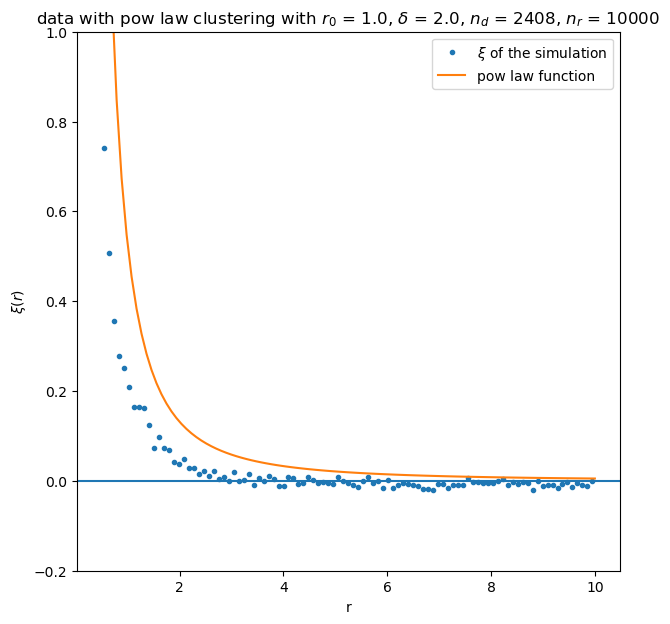

In [8]:
ax = Look_into(r0 = 1.0, delta = 2.0, n_d = 3000, n_r = 10000, bins = np.linspace(0.5, 10, 100))
ax.set_ylim(-0.2, 1)

Total time take = 80.47 s


(-0.2, 1.0)

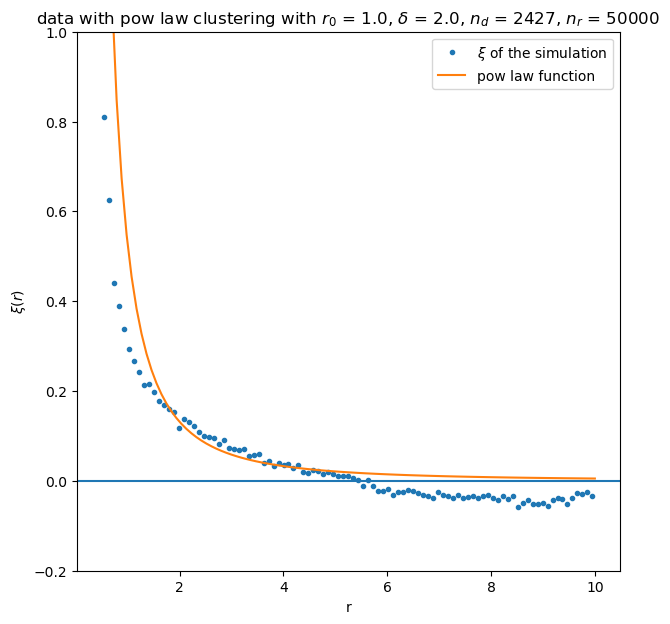

In [9]:
ax = Look_into(r0 = 1.0, delta = 2.0, n_d = 3000, n_r = 50000, bins = np.linspace(0.5, 10, 100))
ax.set_ylim(-0.2, 1)

## Simulating in a shell

In [46]:
global low_r, up_r
low_r = 70
up_r = 100

def make_rand_dist_shell(num):
    z = np.random.uniform(-1, 1, num)
    phi = np.random.uniform(0, 2*np.pi, num)
    theta = np.arccos(z)

    r = np.random.uniform(low_r, up_r, num)

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return x, y, z

def spher_to_cart(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(phi)
    return x, y, z

def make_clust_dist_shell(num, r0, delta):
    r = np.random.uniform(low_r, up_r)
    phi = np.random.uniform(0, 2 * np.pi, 1)[0]
    z = np.random.uniform(-r, r, 1)[0]
    theta = np.arccos(z/r)
    dat_array = np.array(spher_to_cart(r, theta, phi)).reshape(3,1)
    i = 0

    while i < (num - 1):
        r = get_r_from_prob(r0, delta)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arccos(z/r)

        new_add = np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), z])
        new_pt = np.reshape(dat_array[:,-1] + new_add, (3,1))
        if np.sum(pow(new_pt, 2)) < low_r | np.sum(pow(new_pt, 2)) > up_r:
            continue
        
        dat_array = np.append(dat_array, new_pt, axis=1)
        i += 1

    return dat_array

Text(0.5, 0.92, 'Distribution of the unclustered points in a box')

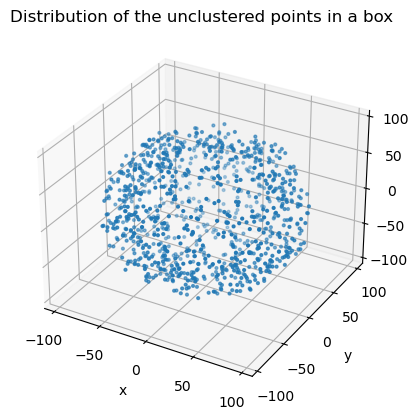

In [47]:
x_ran, y_ran, z_ran = make_rand_dist_shell(1000)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_ran, y_ran, z_ran, s=4)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Distribution of the unclustered points in a box")

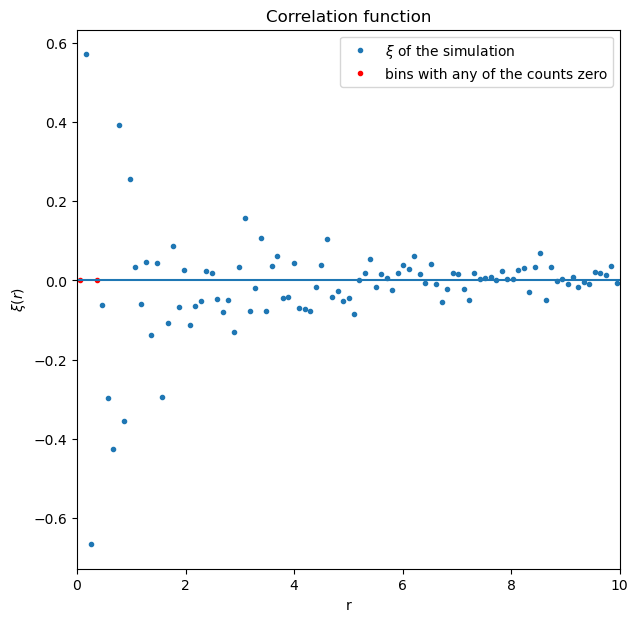

In [119]:
x_ran, y_ran, z_ran = make_rand_dist_shell(100000)
x_ran1, y_ran1, z_ran1 = make_rand_dist_shell(10000)

bins = np.linspace(0.01, 10, 100)
ax = calc_corr_fun(x_ran1, y_ran1, z_ran1, x_ran, y_ran, z_ran, bins)
ax.set_xlim(0, 10);